### Project description

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value.

Rusty Bargain is interested in:
- the quality of the prediction
- the speed of the prediction
- the time required for training

**Goal**

Build a few regression models, and compare their quality of prediction, speed of prediction, and time required to train. The best model will be used to predict the price of a car.

In [12]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from catboost import CatBoostRegressor, CatBoostClassifier
#from lightgbm import LGBMRegressor

import warnings

warnings.filterwarnings('ignore')

### Data preparation

In [16]:
df = pd.read_csv('car_data.csv')

Check the shape of the data set before data preparing.

In [119]:
# shape
df.shape

(354060, 20)

In [18]:
# top 5 records
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


They are NAN in key areas that need to be address.

In [120]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354060 entries, 0 to 354368
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354060 non-null  datetime64[ns]
 1   Price              354060 non-null  int64         
 2   VehicleType        354060 non-null  object        
 3   RegistrationYear   354060 non-null  float64       
 4   Gearbox            354060 non-null  object        
 5   Power              354060 non-null  float64       
 6   Model              354060 non-null  object        
 7   Mileage            354060 non-null  int64         
 8   RegistrationMonth  354060 non-null  float64       
 9   FuelType           354060 non-null  object        
 10  Brand              354060 non-null  object        
 11  NotRepaired        354060 non-null  object        
 12  DateCreated        354060 non-null  datetime64[ns]
 13  NumberOfPictures   354060 non-null  int64   

In [121]:
# missing values
df.isnull().mean().sort_values(ascending=False)

DateCrawled          0.0
Price                0.0
CreateMonth          0.0
CreateYear           0.0
DaysOnSite           0.0
LastSeen             0.0
PostalCode           0.0
NumberOfPictures     0.0
DateCreated          0.0
NotRepaired          0.0
Brand                0.0
FuelType             0.0
RegistrationMonth    0.0
Mileage              0.0
Model                0.0
Power                0.0
Gearbox              0.0
RegistrationYear     0.0
VehicleType          0.0
CreateDay            0.0
dtype: float64

In [21]:
# duplicates?
df.duplicated().sum()

262

In [22]:
# percent duplicated
df.duplicated().sum() / df.shape[0]

0.0007393423239617461

In [23]:
# 5 duplicates
df[df.duplicated()].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
14266,21/03/2016 19:06,5999,small,2009,manual,80,polo,125000,5,petrol,volkswagen,no,21/03/2016 00:00,0,65529,05/04/2016 20:47
27568,23/03/2016 10:38,12200,bus,2011,manual,125,zafira,40000,10,gasoline,opel,no,23/03/2016 00:00,0,26629,05/04/2016 07:44
31599,03/04/2016 20:41,4950,wagon,2003,auto,170,e_klasse,150000,4,gasoline,mercedes_benz,no,03/04/2016 00:00,0,48432,05/04/2016 21:17
33138,07/03/2016 20:45,10900,convertible,2005,auto,163,clk,125000,5,petrol,mercedes_benz,no,07/03/2016 00:00,0,61200,21/03/2016 03:45
43656,13/03/2016 20:48,4200,sedan,2003,manual,105,golf,150000,10,gasoline,volkswagen,no,13/03/2016 00:00,0,14482,13/03/2016 20:48


In [24]:
# 5 point summary
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Conclusion**

1) Each observation describes a model of a car; there are 354369 cars and 16 features.

2) The top 2 features with missing values are: `NotRepaired` (20%) and `VehicleType` (11%).

3) 262 (.07%) of the records are duplicated. Given that this data was scraped from a website, this is expected.

4) The numerical summary show outliers for the `Price`, `RegistrationYear`, and `Power`. The `NumberOfPictures` feature has no data.

### Data preparation

#### Fix the date fields

In [25]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%d/%m/%Y %H:%M')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%d/%m/%Y %H:%M')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%d/%m/%Y %H:%M')

In [26]:
df['DateCrawled'].min(), df['DateCrawled'].max()

(Timestamp('2016-03-05 14:06:00'), Timestamp('2016-04-07 14:36:00'))

In [27]:
df['DateCreated'].min(), df['DateCreated'].max() 

(Timestamp('2014-03-10 00:00:00'), Timestamp('2016-04-07 00:00:00'))

In [28]:
df['LastSeen'].min(), df['LastSeen'].max() 

(Timestamp('2016-03-05 14:15:00'), Timestamp('2016-04-07 14:58:00'))

1) The data has been crawled for a period of 1 month.

2) The `DateCreated` ranges for a period of 2 years.

 #### Drop duplicates

In [29]:
df.drop_duplicates(inplace=True)

In [30]:
df.shape

(354107, 16)

#### Create a new field using `LastSeen` and `DateCreated`

In [31]:
df['DaysOnSite'] = (df['LastSeen'] - df['DateCreated']).dt.days

In [32]:
# check for negative days
np.any(df['DaysOnSite'] < 0)

False

#### Create date features from DateCreated

In [33]:
df['CreateYear'] = df['DateCreated'].dt.year
df['CreateMonth'] = df['DateCreated'].dt.month
df['CreateDay'] = df['DateCreated'].dt.day

#### Reduce the number of categories

`Model` has 251 categories including NaN. Reduce it to to the top
80%, and replace the sparsely represented categories with a new
label

In [34]:
# calculate the cumulative percentage
# and identify the top n Models that
# make up 80% of the observations
model_counts = pd.DataFrame(df['Model'].value_counts())


In [35]:
model_counts.head()

,Model
golf,29215
other,24402
3er,19744
polo,13057
corsa,12559


In [36]:
model_counts.shape

(250, 1)

In [37]:
model_cumulative = pd.DataFrame(model_counts['Model'].cumsum() / model_counts['Model'].sum())
models_80pct = model_cumulative[model_cumulative['Model'] < 0.8].index

In [38]:
df['Model'] = df['Model'].apply(lambda x: x if x in models_80pct else 'other')

 #### Populate the missing values for the categorical fields
   
   *NotRepaired* <br/>
   *VehicleType* <br/>
   *FuelType* <br/>
   *Gearbox* <br/>
   *Model*

In [39]:
def category_distribution(df, field):
    """
    Distribution of categorical features
    """
    print(f'Distribution for {field}')
    print(df[field].value_counts(normalize=True, dropna=False))
    print()

In [40]:
cat_cols = ['NotRepaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model']
for col in cat_cols:
    category_distribution(df, col)

Distribution for NotRepaired
no     0.697323
NaN    0.200914
yes    0.101763
Name: NotRepaired, dtype: float64

Distribution for VehicleType
sedan          0.258111
small          0.225223
wagon          0.183885
NaN            0.105855
bus            0.081196
convertible    0.056988
coupe          0.045599
suv            0.033863
other          0.009280
Name: VehicleType, dtype: float64

Distribution for FuelType
petrol      0.610440
gasoline    0.278611
NaN         0.092879
lpg         0.014987
cng         0.001596
hybrid      0.000658
other       0.000576
electric    0.000254
Name: FuelType, dtype: float64

Distribution for Gearbox
manual    0.756929
auto      0.187071
NaN       0.056000
Name: Gearbox, dtype: float64

Distribution for Model
other          0.313950
golf           0.082503
3er            0.055757
polo           0.036873
corsa          0.035467
astra          0.030499
passat         0.028627
a4             0.027941
c_klasse       0.023459
5er            0.022200
e_klas

In [41]:
def populate_missing_categories(df, field):
    """
    Populate missing categories
    """
    np.random.seed(42)
    a = df[field].value_counts().index
    p = df[field].value_counts(normalize=True).values
    size = df[field].isnull().sum()
    values = np.random.choice(a, p=p, size=size)
    return values

In [42]:
bin_cols = ['NotRepaired', 'Gearbox']
for col in bin_cols:
    print(f'Populate missing values for {col}')
    df.loc[df[col].isnull(), col] = populate_missing_categories(df, col)
    print(populate_missing_categories(df, col))

Populate missing values for NotRepaired
[]
Populate missing values for Gearbox
[]


In [43]:
def build_model_to_populate_missing_feats(model, df, target, 
                hyperparameters={}, 
                scoring=None,
                cv=2, frac=0.4, drop_feats=[], cat_features=[], verbose=False):
    """
    Build model to populate missing categorical features
    """
    np.random.seed(42)
    start_time = time.time()
    data = df.copy(deep=True)
    data.drop(drop_feats, axis=1, inplace=True)
    data[cat_features] = data[cat_features].replace(np.nan, 'nan')
    oe = OrdinalEncoder()
    data[cat_features] = oe.fit_transform(data[cat_features]).astype(np.uint16)
    train_X, train_y = (
                        data[data[target].notnull()].drop([target], axis=1).sample(frac=frac, random_state=42),
                        data[data[target].notnull()][target].sample(frac=frac, random_state=42)
    )
    test_X = data[data[target].isnull()].drop([target], axis=1)
    print(f'Shape of train set is {train_X.shape} and test set is {test_X.shape}')
    del data
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    
    gs.best_estimator_.fit(train_X, train_y, cat_features=cat_features, verbose=verbose)
    preds = gs.best_estimator_.predict(test_X)
    df.loc[df[target].isnull(), target] = preds
    end_time = time.time() - start_time
    del train_X, test_X, train_y
    print(f'Time taken to complete predictions for {target} is {end_time} seconds')

In [44]:
drop_feats = ['DateCrawled', 'DateCreated', 'LastSeen']
cat_spl_features = ['Gearbox', 'Brand',
               'Model', 'FuelType', 'NotRepaired', 'CreateYear', 'CreateMonth', 
               'CreateDay', 'PostalCode']
cat_classifier = CatBoostClassifier(
                        learning_rate=0.9, 
                        loss_function='MultiClass',
                        early_stopping_rounds=5,
                        depth=9,
                        eval_metric='TotalF1',
                        random_seed=42)
target = 'VehicleType'
build_model_to_populate_missing_feats(cat_classifier, 
                                      df, target, 
                                      hyperparameters={'iterations': [10]}, 
                                      scoring='f1_weighted', 
                                      cv=2,
                                      drop_feats=drop_feats,
                                      cat_features=cat_spl_features
                                     )

Shape of train set is (126649, 16) and test set is (37484, 16)
0:	learn: 0.5053357	total: 460ms	remaining: 4.14s
1:	learn: 0.5114258	total: 887ms	remaining: 3.55s
2:	learn: 0.5490963	total: 1.31s	remaining: 3.06s
3:	learn: 0.5653869	total: 1.7s	remaining: 2.55s
4:	learn: 0.5808965	total: 2.12s	remaining: 2.12s
5:	learn: 0.5959794	total: 2.54s	remaining: 1.7s
6:	learn: 0.6083286	total: 2.95s	remaining: 1.26s
7:	learn: 0.6124681	total: 3.37s	remaining: 843ms
8:	learn: 0.6201193	total: 3.78s	remaining: 421ms
9:	learn: 0.6257875	total: 4.18s	remaining: 0us
0:	learn: 0.5128019	total: 412ms	remaining: 3.71s
1:	learn: 0.5207030	total: 796ms	remaining: 3.18s
2:	learn: 0.5581655	total: 1.22s	remaining: 2.84s
3:	learn: 0.5720340	total: 1.61s	remaining: 2.42s
4:	learn: 0.5844812	total: 2.04s	remaining: 2.04s
5:	learn: 0.6014577	total: 2.46s	remaining: 1.64s
6:	learn: 0.6076825	total: 2.84s	remaining: 1.22s
7:	learn: 0.6146583	total: 3.27s	remaining: 817ms
8:	learn: 0.6237827	total: 3.69s	remainin

In [45]:
# check if feat is populated
df['VehicleType'].isnull().sum()

0

In [46]:
drop_feats = ['DateCrawled', 'DateCreated', 'LastSeen']
cat_spl_features = ['VehicleType', 'Gearbox', 'Brand',
               'Model', 'NotRepaired', 'CreateYear', 'CreateMonth', 
               'CreateDay', 'PostalCode']
cat_classifier = CatBoostClassifier(
                        learning_rate=0.9, 
                        loss_function='MultiClass',
                        early_stopping_rounds=5,
                        depth=9,
                        eval_metric='TotalF1',
                        random_seed=42)
target = 'FuelType'
build_model_to_populate_missing_feats(cat_classifier, 
                                      df, target, 
                                      hyperparameters={'iterations': [10]}, 
                                      scoring='f1_weighted', 
                                      cv=2,
                                      frac=0.2,
                                      drop_feats=drop_feats,
                                      cat_features=cat_spl_features
                                     )

Shape of train set is (64244, 16) and test set is (32889, 16)
0:	learn: 0.7776436	total: 214ms	remaining: 1.93s
1:	learn: 0.6527087	total: 425ms	remaining: 1.7s
2:	learn: 0.7792688	total: 617ms	remaining: 1.44s
3:	learn: 0.7890679	total: 829ms	remaining: 1.24s
4:	learn: 0.7915004	total: 1.04s	remaining: 1.04s
5:	learn: 0.7987925	total: 1.25s	remaining: 833ms
6:	learn: 0.8036533	total: 1.46s	remaining: 628ms
7:	learn: 0.8095732	total: 1.68s	remaining: 419ms
8:	learn: 0.8131531	total: 1.88s	remaining: 209ms
9:	learn: 0.8147746	total: 2.1s	remaining: 0us
0:	learn: 0.7547202	total: 211ms	remaining: 1.9s
1:	learn: 0.6780162	total: 416ms	remaining: 1.66s
2:	learn: 0.7583627	total: 617ms	remaining: 1.44s
3:	learn: 0.7737752	total: 832ms	remaining: 1.25s
4:	learn: 0.7928433	total: 1.04s	remaining: 1.04s
5:	learn: 0.8038814	total: 1.25s	remaining: 836ms
6:	learn: 0.8089042	total: 1.47s	remaining: 628ms
7:	learn: 0.8128231	total: 1.68s	remaining: 421ms
8:	learn: 0.8172852	total: 1.89s	remaining:

In [47]:
# check if feat is populated
df['FuelType'].isnull().sum()

0

In [48]:
# check distribution of categorical features after populating missing values
for col in cat_cols:
    category_distribution(df, col)

Distribution for NotRepaired
no     0.872892
yes    0.127108
Name: NotRepaired, dtype: float64

Distribution for VehicleType
sedan          0.294151
small          0.256140
wagon          0.201106
bus            0.092435
convertible    0.059982
coupe          0.047669
suv            0.036585
other          0.011931
Name: VehicleType, dtype: float64

Distribution for FuelType
petrol      0.682746
gasoline    0.298958
lpg         0.015193
cng         0.001598
hybrid      0.000675
other       0.000576
electric    0.000254
Name: FuelType, dtype: float64

Distribution for Gearbox
manual    0.801831
auto      0.198169
Name: Gearbox, dtype: float64

Distribution for Model
other          0.313950
golf           0.082503
3er            0.055757
polo           0.036873
corsa          0.035467
astra          0.030499
passat         0.028627
a4             0.027941
c_klasse       0.023459
5er            0.022200
e_klasse       0.019144
a3             0.017289
focus          0.016571
fiesta        

1) Overall, it appears that the distribution hasn't changed significantly.

In [49]:
# post fixing of missing values has produced 35 duplicates
df.duplicated().sum()

35

#### Drop duplicates post filling missing categorical features

In [50]:
df.drop_duplicates(inplace=True)

#### Plot histograms

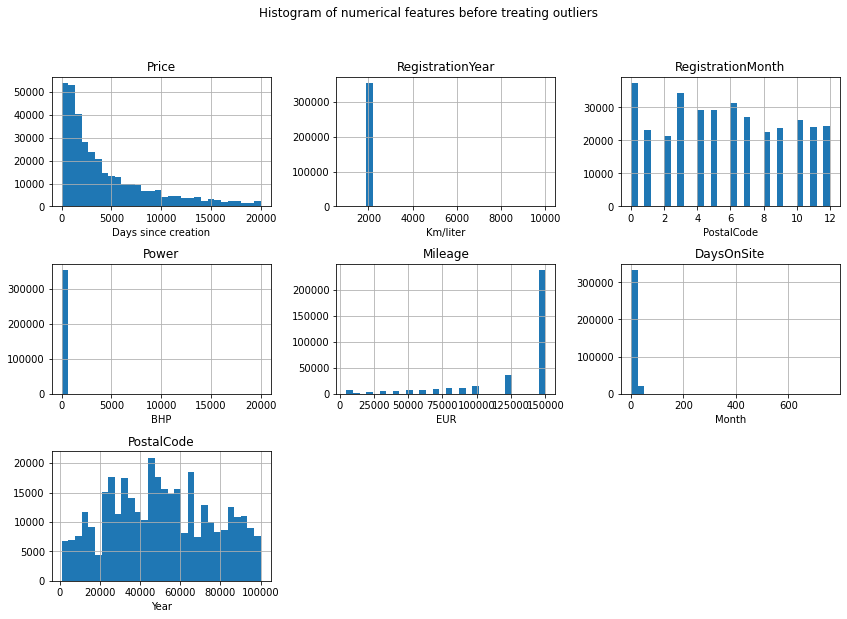

In [51]:
hist_cols = ['Price', 'RegistrationYear', 'RegistrationMonth', 'Power', 'Mileage',
            'DaysOnSite', 'PostalCode']
xlabels = [['Days since creation', 'Km/liter', 'PostalCode'], 
          ['BHP', 'EUR', 'Month'],
          ['Year']]
fig, ax = plt.subplots(figsize=(12, 9))
axes = df[hist_cols].hist(bins=30, ax=ax)
for i in range(len(axes)):
    for j in range(len(axes)):
        if i == 2 and j > 0: continue
        axes[i][j].set_xlabel(xlabels[i][j])
plt.suptitle('Histogram of numerical features before treating outliers')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

1) The `Price` is right-skewed; there are observations with very low priced cars, which is abnormal.

2) Majority of the `RegistrationYear` is year 2000. However, we know that there are outliers here; the same applies
to `Power`.

**Possible fix**

1) Analysis of `Power` 
we will cap the lower range to 100 HP and the higher end to 2000 HP.

2) Since `Price` is subjective, we will cap the lower end to EUR 50.

3) For `RegistrationYear`, the lower bound will be 1900 and the upper bound is 2021.

4) `RegistrationMonth` with value of 0 will be replaced by the probability of occurrence of the other months.

5) `FuelType` and `VehicleType` were populated using a CatBoostClassifier model.

#### Investigate the  outliers

In [52]:
def identify_outliers(df, field):
    """
    Identify outliers
    """
    Q1 = df[field].quantile(.25)
    Q3 = df[field].quantile(.75)
    IQR = Q3 - Q1
    lb = Q1 - 1.5 * IQR
    ub = Q3 + 1.5 * IQR
    return lb, ub

In [53]:
# Price with EUR < 50
df[df['Price'] < 50].shape

(12420, 20)

In [54]:
# how much data are we throwing
df[df['Price'] < 50].shape[0] / df.shape[0]

0.03507761133328814

In [55]:
df[df['Price'] < 50].describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode,DaysOnSite,CreateYear,CreateMonth,CreateDay
count,12420.000000,12420.000000,12420.000000,12420.000000,12420.000000,12420.0,12420.000000,12420.000000,12420.0,12420.000000,12420.000000
mean,0.893156,2008.495572,79.470773,121469.404187,3.600483,0.0,45399.282448,7.517955,2016.0,3.156441,16.045813
std,4.753588,262.170104,227.383905,50988.365939,4.022439,0.0,26368.614495,8.117499,0.0,0.365057,9.117634
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1069.000000,0.000000,2016.0,1.000000,1.000000
25%,0.000000,1996.000000,0.000000,125000.000000,0.000000,0.0,25746.000000,1.000000,2016.0,3.000000,8.000000
50%,0.000000,2000.000000,73.000000,150000.000000,2.000000,0.0,44269.000000,4.000000,2016.0,3.000000,16.000000
75%,0.000000,2005.000000,118.000000,150000.000000,7.000000,0.0,64319.000000,11.000000,2016.0,3.000000,24.000000
max,49.000000,9999.000000,15016.000000,150000.000000,12.000000,0.0,99996.000000,59.000000,2016.0,4.000000,31.000000


In [56]:
# Power
df[(df['Power'] < 100) | (df['Power'] > 2000)].shape

(154279, 20)

In [57]:
# how much data are we throwing
df[(df['Power'] < 100) | (df['Power'] > 2000)].shape[0] / df.shape[0]

0.4357277615852143

In [58]:
df[(df['Power'] < 100) | (df['Power'] > 2000)].describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode,DaysOnSite,CreateYear,CreateMonth,CreateDay
count,154279.000000,154279.000000,154279.000000,154279.000000,154279.000000,154279.0,154279.000000,154279.000000,154279.000000,154279.000000,154279.000000
mean,2422.979589,2004.529158,58.571173,123508.060073,5.288601,0.0,48588.453322,8.151155,2015.999916,3.157954,15.907214
std,2786.392513,132.792728,269.796653,41605.015466,3.857711,0.0,25378.256858,8.585703,0.009860,0.372681,9.100894
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000,0.000000,2014.000000,1.000000,1.000000
25%,650.000000,1998.000000,0.000000,100000.000000,2.000000,0.0,27749.000000,2.000000,2016.000000,3.000000,8.000000
50%,1400.000000,2001.000000,60.000000,150000.000000,5.000000,0.0,47259.000000,5.000000,2016.000000,3.000000,16.000000
75%,3150.000000,2007.000000,75.000000,150000.000000,9.000000,0.0,66687.000000,12.000000,2016.000000,3.000000,24.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000,759.000000,2016.000000,12.000000,31.000000


In [59]:
# RegistrationYear
df[(df['RegistrationYear'] < 1900) | (df['RegistrationYear'] > 2021)].shape

(171, 20)

In [60]:
# how much data are we throwing
df[(df['RegistrationYear'] < 1900) | (df['RegistrationYear'] > 2021)].shape[0] / df.shape[0]

0.0004829526198061411

In [61]:
# RegistrationMonth
df[(df['RegistrationMonth'] == 0) ].shape

(37346, 20)

In [62]:
# how much data are we throwing
df[(df['RegistrationMonth'] == 0) ].shape[0] / df.shape[0]

0.10547572245193068

1) `Power` has almost 44% of the observations where the value is either below 100 HP or above 2000 HP. So, we cannot
just remove these records. So, the next best alternative is to replace these extremes with the median.

In [63]:
# replace the extreme Power values with the median
print(f"The median Power is {df['Power'].median()} and the mean is {df['Power'].mean()}")

The median Power is 105.0 and the mean is 110.08857802932737


In [64]:
mask = (df['Power'] < 100) | (df['Power'] > 2000)
df.loc[mask, 'Power'] = df['Power'].median()

In [65]:
# replace the extreme RegistrationYear values with the median
print(f"The median Power is {df['RegistrationYear'].median()} and the mean is {df['RegistrationYear'].mean()}")

The median Power is 2003.0 and the mean is 2004.2357175941615


In [66]:
mask = (df['RegistrationYear'] < 1900) | (df['RegistrationYear'] > 2021)
df.loc[mask, 'RegistrationYear'] = df['RegistrationYear'].median()

In [67]:
# replace the extreme RegistrationMonth values with the median
print(f"The median Power is {df['RegistrationMonth'].median()} and the mean is {df['RegistrationMonth'].mean()}")

The median Power is 6.0 and the mean is 5.714066630515827


In [68]:
# Model has too many features to predict causing the notebook to crash
df['Model'] = (
df.groupby(['Brand', 'RegistrationYear'])['Model']
                  .transform(lambda x: x.fillna((x.mode() if np.all(x.mode()) == True else 'other')))
)

In [69]:
# check if Model has missing values
df['Model'].isnull().sum()

0

In [70]:
# fill them with other
#df['Model'].fillna('other', inplace=True)

In [71]:
# check if Model has missing values
df['Model'].isnull().sum()

0

In [72]:
mask = (df['RegistrationMonth'] == 0)
df.loc[mask, 'RegistrationMonth'] = df['RegistrationMonth'].median()

In [73]:
# check for duplicates post fixing outliers
df.duplicated().sum()

12

In [74]:
# remove duplicates from outlier fixing
df.drop_duplicates(inplace=True)

In [75]:
# remove Price below EUR 50
new_df = df[df['Price'] >= 50].copy()

In [76]:
new_df.shape

(341640, 20)

In [77]:
# pct lost
1 - new_df.shape[0]/df.shape[0]

0.03507880020335541

In [78]:
# check for duplicates in new_df
new_df.duplicated().sum()

0

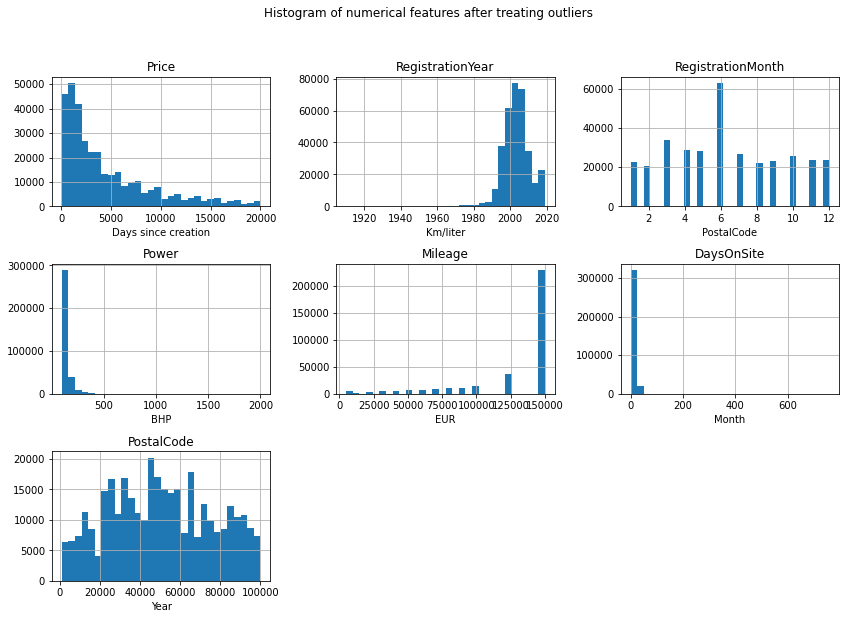

In [79]:
# replot the numerical features post fixing outliers
fig, ax = plt.subplots(figsize=(12, 9))
axes = new_df[hist_cols].hist(bins=30, ax=ax)
for i in range(len(axes)):
    for j in range(len(axes)):
        if i == 2 and j > 0: continue
        axes[i][j].set_xlabel(xlabels[i][j])
plt.suptitle('Histogram of numerical features after treating outliers')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

1) Post cleanup of the outliers, the distributions for `Power`, `RegistrationYear`, `RegistrationMonth` have improved.

#### Encode the categorical features

In [80]:
encode_cols = ['PostalCode']
encode_cols += new_df.select_dtypes(include=['object']).columns.tolist()
oe = OrdinalEncoder()
new_df[encode_cols] = oe.fit_transform(new_df[encode_cols])

In [81]:
new_df.duplicated().sum()

0

#### Drop features not used during modeling

In [82]:
drop_cols = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen']
new_df.drop(drop_cols, axis=1, inplace=True)

In [83]:
new_df.shape

(341640, 16)

In [84]:
# pct dropped
1 - new_df.shape[0] / df.shape[0]

0.03507880020335541

In [85]:
new_df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,DaysOnSite,CreateYear,CreateMonth,CreateDay
0,480,5.0,1993.0,1.0,105.0,26.0,150000,6.0,6.0,38.0,0.0,4896.0,14,2016,3,24
1,18300,2.0,2011.0,1.0,190.0,38.0,125000,5.0,2.0,1.0,1.0,4613.0,14,2016,3,24
2,9800,6.0,2004.0,0.0,163.0,38.0,125000,8.0,2.0,14.0,1.0,6989.0,22,2016,3,14
3,1500,5.0,2001.0,1.0,105.0,26.0,150000,6.0,6.0,38.0,0.0,7029.0,0,2016,3,17
4,3600,5.0,2008.0,1.0,105.0,21.0,90000,7.0,2.0,31.0,0.0,4210.0,6,2016,3,31


In [86]:
# check for missing
new_df.isnull().mean()

Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Mileage              0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
NotRepaired          0.0
PostalCode           0.0
DaysOnSite           0.0
CreateYear           0.0
CreateMonth          0.0
CreateDay            0.0
dtype: float64

In [87]:
# check for duplicates
new_df.duplicated().sum()

8013

In [88]:
# dropping the DateCrawled field has introduced duplicates
new_df.drop_duplicates(inplace=True)

In [89]:
# check dtypes
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333627 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              333627 non-null  int64  
 1   VehicleType        333627 non-null  float64
 2   RegistrationYear   333627 non-null  float64
 3   Gearbox            333627 non-null  float64
 4   Power              333627 non-null  float64
 5   Model              333627 non-null  float64
 6   Mileage            333627 non-null  int64  
 7   RegistrationMonth  333627 non-null  float64
 8   FuelType           333627 non-null  float64
 9   Brand              333627 non-null  float64
 10  NotRepaired        333627 non-null  float64
 11  PostalCode         333627 non-null  float64
 12  DaysOnSite         333627 non-null  int64  
 13  CreateYear         333627 non-null  int64  
 14  CreateMonth        333627 non-null  int64  
 15  CreateDay          333627 non-null  int64  
dtypes:

In [90]:
def convert_dtype(df, field, dtype=np.uint8):
    """
    Convert the dtype
    """
    try:
        df[field] = df[field].astype(dtype)
    except:
        print(f'Failed to change dtype for {field}')

In [91]:
dtype_cols = {
    'VehicleType': np.uint8,
    'RegistrationYear': np.uint16,
    'Gearbox': np.uint8,
    'Power': np.uint8,
    'Model': np.uint8,
    'RegistrationMonth': np.uint8,
    'FuelType': np.uint8,
    'Brand': np.uint8,
    'NotRepaired': np.uint8,
    'PostalCode': np.uint32,
    'DaysOnSite': np.uint16,
    'CreateYear': np.uint16,
    'CreateMonth': np.uint8,
    'CreateDay': np.uint8
}

In [92]:
for col in dtype_cols:
    print(f'Conversion for {col}')
    convert_dtype(new_df, col, dtype_cols[col])

Conversion for VehicleType
Conversion for RegistrationYear
Conversion for Gearbox
Conversion for Power
Conversion for Model
Conversion for RegistrationMonth
Conversion for FuelType
Conversion for Brand
Conversion for NotRepaired
Conversion for PostalCode
Conversion for DaysOnSite
Conversion for CreateYear
Conversion for CreateMonth
Conversion for CreateDay


In [93]:
# check dtypes
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333627 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              333627 non-null  int64 
 1   VehicleType        333627 non-null  uint8 
 2   RegistrationYear   333627 non-null  uint16
 3   Gearbox            333627 non-null  uint8 
 4   Power              333627 non-null  uint8 
 5   Model              333627 non-null  uint8 
 6   Mileage            333627 non-null  int64 
 7   RegistrationMonth  333627 non-null  uint8 
 8   FuelType           333627 non-null  uint8 
 9   Brand              333627 non-null  uint8 
 10  NotRepaired        333627 non-null  uint8 
 11  PostalCode         333627 non-null  uint32
 12  DaysOnSite         333627 non-null  uint16
 13  CreateYear         333627 non-null  uint16
 14  CreateMonth        333627 non-null  uint8 
 15  CreateDay          333627 non-null  uint8 
dtypes: int64(2), uint16(

In [94]:
# pct dropped
1 - new_df.shape[0] / df.shape[0]

0.057710557532621554

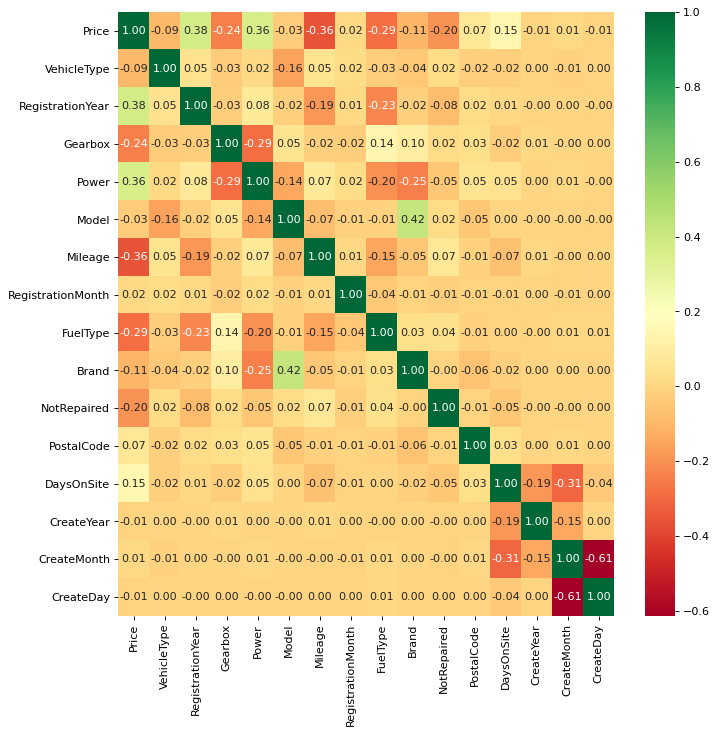

In [95]:
#### Correlation
plt.figure(figsize=(10, 10), dpi=80)
sns.heatmap(new_df.corr(), annot=True, cmap="RdYlGn", fmt=".2f")
plt.show()

1) Ignoring the categorical features, we can see that `RegistrationYear` has a moderately strong positive correlation with `Price`.

2) Similarly, `Power` a moderately strong positive correlation with `Price`.

3) As expected, `Mileage` is negatively correlated with `Price`.

4) Among the categorical features, `Brand` and `Model` have a positive correlation.

**Conclusion**

1) The time period of car ads posted on the source site are around 2 years old.

2) A few new fields were created. One of the fields created shows the number of days the ad appears on the site. The other fields
are date attributes created from `DateCreated`.

3) Missing categorical features were populated using the frequency distribution of occurence of their respective features; this
ensures that those features that occur more frequently are weighted more compared with those that occur rarely.

4) A side effect of populating the missing categories introduced duplicates. However, this number is less than 1%.

5) The numerical features exhibited outliers, and each of them were treated after identifying suitable ranges based on
some research conducted online. For example, `Power` range was fixed between 100 HP and 2000 HP. Anything below or above
this was replaced by the median of the `Power` distribution. A similar approach was used for the other ouliers.

6) This introduced duplicates, a very tiny number, which were removed.

7) The categorical features were encoded to allow for smooth modeling.

8) All Date related features, including `NumOfPictures` were removed. The latter feature had no values.

9) Removal of `DateCrawled` introduced duplicates, around 3.5% of the records were affected. These were removed.

10) Label Encoding resulted in a change in data type; this was fixed to reduce the size of the dataset.

11) Overall, the cleaning resulted in a loss of 5.75% of the data.

### Model training

In [106]:
train_X, test_X, train_y, test_y = train_test_split(new_df.drop(['Price'], axis=1),
                                                      new_df['Price'], test_size=0.2, random_state=42)
valid_X, test_X, valid_y, test_y = train_test_split(test_X,
                                                      test_y, test_size=0.1, random_state=42)

In [107]:
train_X.shape, valid_X.shape, test_X.shape, train_y.shape, valid_y.shape, test_y.shape

((266901, 15), (60053, 15), (6673, 15), (266901,), (60053,), (6673,))

In [108]:
def rmse(y_true, y_pred):
    """
    Make scorer to compute rmse
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [109]:
def build_model(model, train_X, train_y, valid_X, valid_y, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], verbose=False):
    """
    Build model
    """
    np.random.seed(42)
    best_rmse = 0
    start_time = time.time()
    
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'catboost':
        gs.best_estimator_.fit(train_X, train_y, cat_features=cat_features, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict(valid_X)
    best_rmse = rmse(valid_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_rmse, np.round(end_time, 2)

In [110]:
lr = LinearRegression()
best_lr_model, best_lr_rmse, best_lr_time = build_model(lr, train_X, train_y, 
                                                        valid_X, valid_y,
                                                        hyperparameters={}, 
                scoring=make_scorer(rmse), cv=5, model_str='lr')

In [111]:
rf = RandomForestRegressor(random_state=42)
best_rf_model, best_rf_rmse, best_rf_time = build_model(rf, train_X, train_y, 
                                                        valid_X, valid_y,
                                                        hyperparameters={'n_estimators': [20, 30, 40, 50]}, 
                scoring=make_scorer(rmse), cv=5)

In [112]:
cat_features = ['VehicleType',  'Gearbox', 'Brand',
               'Model', 'FuelType', 'NotRepaired', 'CreateYear', 'CreateMonth', 
               'CreateDay', 'PostalCode']
cat = CatBoostRegressor(learning_rate=0.9, loss_function='RMSE',
                        random_seed=42)
best_cb_model, best_cb_rmse, best_cb_time = build_model(cat, train_X, train_y, 
                                                        valid_X, valid_y,
                                                        hyperparameters={'iterations': [20, 30, 40, 50]}, 
                scoring=make_scorer(rmse), cv=5, model_str='catboost',
           cat_features=cat_features)

0:	learn: 2805.2999879	total: 50ms	remaining: 951ms
1:	learn: 2491.2318921	total: 101ms	remaining: 905ms
2:	learn: 2353.6296972	total: 156ms	remaining: 881ms
3:	learn: 2252.3129314	total: 208ms	remaining: 832ms
4:	learn: 2198.2172109	total: 256ms	remaining: 769ms
5:	learn: 2130.9024922	total: 301ms	remaining: 702ms
6:	learn: 2094.2556524	total: 346ms	remaining: 642ms
7:	learn: 2069.3780974	total: 403ms	remaining: 605ms
8:	learn: 2036.0114078	total: 458ms	remaining: 559ms
9:	learn: 2017.6011455	total: 516ms	remaining: 516ms
10:	learn: 1997.7719326	total: 562ms	remaining: 460ms
11:	learn: 1981.8248894	total: 616ms	remaining: 410ms
12:	learn: 1969.9750809	total: 663ms	remaining: 357ms
13:	learn: 1958.3993572	total: 711ms	remaining: 305ms
14:	learn: 1947.4333316	total: 770ms	remaining: 257ms
15:	learn: 1935.1624524	total: 836ms	remaining: 209ms
16:	learn: 1930.5157605	total: 876ms	remaining: 155ms
17:	learn: 1920.7227300	total: 925ms	remaining: 103ms
18:	learn: 1909.7147389	total: 967ms	re

In [113]:
model_results_df = pd.DataFrame({'model': ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor'],
              'best_rmse': [best_lr_rmse, best_rf_rmse, best_cb_rmse],
              'train_time': [best_lr_time, best_rf_time, best_cb_time]})

In [114]:
model_results_df

,model,best_rmse,train_time
0,LinearRegression,3316.204235,1.97
1,RandomForestRegressor,1726.915338,1295.06
2,CatBoostRegressor,1885.075701,53.40


In [115]:
# best features from rf model
pd.DataFrame(best_rf_model.feature_importances_, index=new_df.columns[1:].tolist()).sort_values(0, ascending=False)

,0
RegistrationYear,0.488854
Power,0.235233
Mileage,0.048230
Brand,0.045522
VehicleType,0.038377
PostalCode,0.032105
DaysOnSite,0.025491
Model,0.022051
CreateDay,0.019529
RegistrationMonth,0.017869


In [116]:
# best features from cb model
pd.DataFrame(best_cb_model.feature_importances_, index=new_df.columns[1:].tolist()).sort_values(0, ascending=False)

,0
RegistrationYear,56.568592
Power,21.499296
Brand,7.387881
VehicleType,4.773450
Mileage,4.634478
Model,1.377310
NotRepaired,1.200897
DaysOnSite,1.001701
FuelType,0.929433
Gearbox,0.227676


1) The RandomForestRegressor and CatBoostRegressor were trained using GridSearch with a CrossValidation of 5 folds. For the sake of time, only 1 hyperparameter was tuned - n_estimators/iterations
2) The RandomForestRegressor has the worst performance with respect to training time; it has taken 924 seconds. Whereas,
LinearRegression took the least amount of time - 1.89 seconds. However, on the validation set, RandomForestRegressor has
the best RMSE of EUR 1719

3) The top 3 important features from RandomForest are: `RegistrationYear`, `Power`, and `Mileage`. For CatBoost, they are: `RegistrationYear`, `Power`, and `Brand`. So, we can see a difference in how the algorithms have chosen their best features.

### Model analysis

In [117]:
def test_prediction(model, test_X, test_y):
    """
    Predict RMSE on the test set
    """
    start_time = time.time()
    preds = model.predict(test_X)
    return np.round(time.time(), 2) - start_time, rmse(test_y, preds)

In [ ]:
models = [best_lr_model, best_rf_model, best_cb_model]
for model in models:
    pred_time, best_rmse = test_prediction(model, test_X, test_y)
    print(f'The RMSE on the test set is {best_rmse}, and time to predict {pred_time} seconds')

1) The results of testing the best models on the test set reveal that RandomForestRegressor has the best RMSE; However, the predictions took 280 milliseconds. 

2) However, all the 3 models have slightly overfit.

**Summary**

1) RustyBargain will have to make a compromise between a 7x increase in training time versus a +/- 1.1x increase in RMSE 
should it decide between the top 2 models - RandomForestRegression and CatBoostRegression.

2) However, CatBoostRegressor offers several hyperparameters to play with, and increasing the number of iterations, 
and adding regularization may help in achieving a better RMSE. Therefore, in my view, it should pick CatBoostRegression
simply because it is really fast, and it offers several options to improve the evaluation metric.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed